# COLOR DETECTION

In [1]:
import sys
sys.path.append('/Users/daniel/OAN/SID/')
import pandas

from dotenv import load_dotenv
 
load_dotenv(dotenv_path='/Users/daniel/OAN/SID/.env')

True

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import re
import time
import random
import os

In [3]:
import seaborn as sns

In [4]:
from scipy import ndimage
from tqdm import tqdm

In [5]:
def display(img,cmap=None):
    if cmap == 'gray':
        im=img
    else:
        im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(im,cmap=cmap)

In [13]:
def jaccard(b, a):
    """box_X is a tuple of the shape (x1, y1, x2, y2)."""
    side1 = max(0, min(a[2], b[2]) - max(a[0], b[0]))
    side2 = max(0, min(a[3], b[3]) - max(a[1], b[1]))
    inter = side1 * side2
    
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    union = area_a + area_b - inter
    
    return inter / union


def is_valid(box_pred, box_true, threshold=0.2):
    return jaccard(box_pred, box_true) >= threshold

In [14]:
def compute_metrics(true_pos, false_pos, false_neg):
    if (true_pos + false_neg) == 0 or false_pos+true_pos == 0:
        return 0, 0, 0
    """Compute the precision, recall, and f1 score."""
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)

    if precision == 0 or recall == 0:
        return precision, recall, 0

    f1 = 2 / (1 / precision + 1 / recall)
    return precision, recall, f1

In [22]:

def detect_houses(image,vill,df_anot,v,l,s,h,verb=False):
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hls = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    
    #hue = np.where(True,255-hls[:,:,0],0)
    
    val_q =0.95
    sat_q_up = 0.1
    sat_q_d = 0
    light_q_up =1
    light_q_d =0.9

    val = np.where(min(130,np.quantile(hsv[:,:,2], val_q)) < hsv[:,:,2],hsv[:,:,2],0)
    
    # apply morphology open
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    val = v*cv2.morphologyEx(val, cv2.MORPH_OPEN, kernel).astype(np.int32)
    
    sat = np.where(np.logical_and((np.quantile(hls[:,:,2],sat_q_d) < hls[:,:,2]),
                                      (hls[:,:,2] < np.quantile(hls[:,:,2],sat_q_up))
                                     ),255-hls[:,:,2],0
                      )
    
    # apply morphology open
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    sat = s*cv2.morphologyEx(sat, cv2.MORPH_OPEN, kernel).astype(np.int32)
    
    light = np.where(np.logical_and((np.quantile(hls[:,:,1],light_q_d) < hls[:,:,1]),
                                      (hls[:,:,1] < np.quantile(hls[:,:,1],light_q_up))
                                     ),hls[:,:,1],0
                      )
    
     # apply morphology open
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    light = l*cv2.morphologyEx(light, cv2.MORPH_OPEN, kernel).astype(np.int32)
    
    ## FILTER BLUES
    
    c_blue = 0
    suma_pixel = []
    for i_blue in np.arange(8,20,1):
        blue_low= 10*i_blue
        blue_up = 255
        mask_blue = image.copy()
        mask_blue_m = image.copy()
        mask_blue[mask_blue_m[:,:,c_blue] <= blue_low] = [0,0,0]
        mask_blue[blue_low <= mask_blue_m[:,:,c_blue]] = [255,255,255]
        mask_blue[blue_up <= mask_blue_m[:,:,c_blue]] = [0,0,0]

        mask_blue = mask_blue[:,:,0]

        suma = np.sum(mask_blue.astype(np.int64)).astype(np.int64)

        suma_pixel.append({'suma':suma,'b_down':blue_low})

    df_suma =pd.DataFrame(suma_pixel)
    df_suma = df_suma[(10000 < df_suma['suma']) &
                      (df_suma['suma'] < 15000000)].reset_index()
    df_suma['pct_change'] = df_suma['suma'].pct_change().abs()
    df_pctss = df_suma['pct_change']
    df_local_max = df_suma[(df_pctss.shift(1) < df_pctss) & 
            (df_pctss.shift(-1) < df_pctss)].sort_values(by='b_down',
                                                                      ascending= True
                                                        ).reset_index()
    if 0 < len(df_local_max):
        blue_low = df_local_max.iloc[0]['b_down'].max()
        print('b_low',blue_low)
        pos = df_local_max.iloc[0]['suma'].max()
        lot_pos = 100000 < pos
    else:
        blue_low = 100
        lot_pos = False
        print('b_low default',blue_low)

    blue_up = 255
    mask_blue = image.copy()
    mask_blue_m = image.copy()
    mask_blue[mask_blue_m[:,:,c_blue] <= blue_low] = [0,0,0]
    mask_blue[blue_low <= mask_blue_m[:,:,c_blue]] = [255,255,255]
    mask_blue[blue_up <= mask_blue_m[:,:,c_blue]] = [0,0,0]
    
    mask_blue = mask_blue[:,:,0]
    if verb:
        display(mask_blue)
    
     # apply morphology open if there is a lot of positives
    if lot_pos:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_OPEN, kernel)
    
    
    
    th, mask_blue = cv2.threshold(mask_blue,100,255,cv2.THRESH_BINARY)
    
    mask_blue = h*mask_blue.astype(np.int32)
    
    image_hsl = (val +light +sat+ mask_blue)
    
    if verb:
        display(hsv)
        display(val,'gray')
        display(hls)
        display(light,'gray')
        display(sat,'gray')
        display(mask_blue,'gray')
        
        print(np.unique(np.ravel(mask_blue),return_counts=True))
    
    
    image_hsl = (255*image_hsl.astype(np.float32)/image_hsl.max()).astype(np.uint8)
    
    # blur the image
    image_hsl = cv2.GaussianBlur(image_hsl,(5,5),0.5)
    
    if verb:
        display(image_hsl)
    
    th, im_gay = cv2.threshold(image_hsl,130,255,cv2.THRESH_BINARY)
    
    if verb:
        display(im_gay)
        
    

    # apply morphology open
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    im_gay = cv2.morphologyEx(im_gay, cv2.MORPH_OPEN, kernel)
    
    if verb:
        display(im_gay)
        
    # apply morphology close
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    im_gay = cv2.morphologyEx(im_gay, cv2.MORPH_CLOSE, kernel)
    
    if verb:
        display(im_gay)

    # apply morphology erode
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    #im_gay = cv2.morphologyEx(im_gay, cv2.MORPH_ERODE, kernel)
    
    #if verb:
        #display(im_gay)
    
    # apply morphology dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    im_gay = cv2.morphologyEx(im_gay, cv2.MORPH_DILATE, kernel)
    
    if verb:
        display(im_gay)
    

    houses = []
    box_tp = []
    im_draw = image.copy()
    contours, hierarchy = cv2.findContours(im_gay.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    
    df_houss = df_anot[df_anot['im_path'] == vill]

    # For every entry in contours
    for i,c in enumerate(contours):

        # last column in the array is -1 if an external contour (no contours inside of it)
        if hierarchy[0][i][3] == -1:

            if 10 < c.size and c.size < 200 : 
                #print(c.size)
                rect = cv2.minAreaRect(c)
                box = cv2.boxPoints(rect)
                box = np.int0(box)
                x, y = np.min(box,axis=0)
                x_max, y_max = np.max(box,axis=0)
                
                bbox = (x,y,x_max,y_max)
                w, h = x_max -x, y_max - y

                cx = x+w//2
                cy = y+h//2
                cr  = max(w,h)//2

                ## set offset, repeat enlarger ROI
                dr = 2
                dw = w//2+1*dr
                dh = h//2+1*dr
                ##EVALUATION
                
                bbox_2 = (cx-dw,cy-dh,cx+dw,cy+dh)
                bool_tp = df_houss['box'].apply(lambda x: is_valid(bbox_2,x)).any()
                if bool_tp:
                    box_tp.append(bbox_2)
                    cv2.rectangle(im_draw, (cx-dw, cy-dh), (cx+dw, cy+dh), (0,255,0), 1)
                else:
                    cv2.rectangle(im_draw, (cx-dw, cy-dh), (cx+dw, cy+dh), (0,0,255), 1)


                #cv2.drawContours(im_draw,[box],0,(0,0,255),2)
                # We can now draw the external contours from the list of contours
                #cv2.drawContours(im_draw, contours, i, (255, 0, 0), 1)

               #M = cv2.moments(c)
               #if 0 != M["m00"]:
               #    cX = int(M["m10"] / M["m00"])
               #    cY = int(M["m01"] / M["m00"])
               #    cv2.circle(im_draw, (cX, cY), 1, (0, 0, 255), -1)
               #    
                    
                        
                    
                    

                houses.append(bbox_2)
                
                
                    
                    
                
    #display(im_draw)
    
    return im_draw,houses,box_tp

## GLOBAL VARIABLES

In [16]:
train_path = '/Users/daniel/OAN/SID/dataset/train/'

### READ ANNOTATIONS

In [8]:
df_anot = pd.read_csv(train_path+'_annotations.csv',header=None)

In [9]:
df_anot.columns = ['im_path','l','t','r','b','type']

In [11]:
df_anot['house'] =df_anot.apply(lambda x:
                                  [
                                      [x['l'],x['t']],
                                      [x['l'],x['b']],
                                      [x['r'],x['b']],
                                      [x['r'],x['t']]
                                  ]
                                 ,axis=1)

In [12]:
df_anot['box'] = df_anot.apply(lambda x: (x['l'],x['t'],x['r'],x['b']),axis=1)

### Open Image

In [7]:
images_routes = [im_route 
          for im_route in os.listdir(train_path)
          if 'jpg' in im_route]

In [80]:
vills = [vil for vil in images_routes if vil.split('.')[0] == '1JhDdg8O_fosVOdn6szTA3mMPmg10InAp_2_png']
print(vill)

1JhDdg8O_fosVOdn6szTA3mMPmg10InAp_2_png.rf.091d43b26e849f0da04ff6ea9ff4150f.jpg


In [413]:
vill = random.choice(images_routes)
vill

'1aWhF_2wt-Hest8gjnZvfsWuvUsV8IZ8r_7_png.rf.e869f991462bebf0ac1f39e7390f0346.jpg'

In [82]:
vill = vills[0]
print(vill)

1JhDdg8O_fosVOdn6szTA3mMPmg10InAp_2_png.rf.091d43b26e849f0da04ff6ea9ff4150f.jpg


In [83]:
image = cv2.imread(train_path+vill)

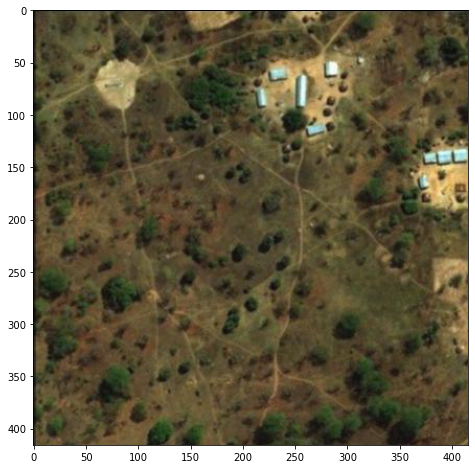

In [84]:
display(image)

In [10]:
df_anot[df_anot['im_path']==vill].head()

NameError: name 'vill' is not defined

In [18]:
v = image.copy()
g_cont = []
houses_im = df_anot[df_anot['im_path']==vill]['house'].to_list()
for c in houses_im:
    pts = np.array(c)
    a=cv2.polylines(v,[pts],isClosed=True,color=(0,0,255),thickness=1)
    g_cont.append(c)

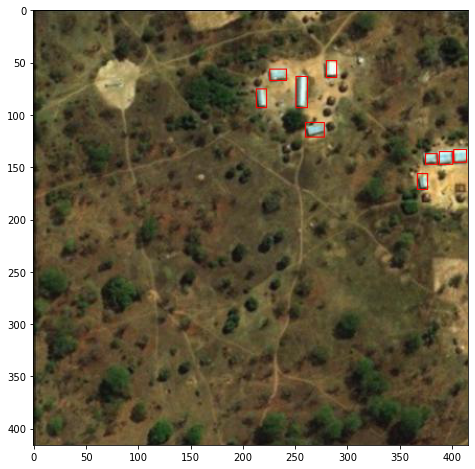

In [19]:
display(v)

In [806]:
vill = random.choice(images_routes)
vill

'89_JPG.rf.5335e5de564c7ca99771286f32adb943.jpg'

In [807]:
im_path = '17_JPG.rf.e817cc606bffb7bdd1691ac7650cffa1.jpg'
im_path = '1DSneo4A8uBgd9QQJF-npDiLdjBHpfrpT_2_png.rf.32e3e38fc6cd08bc77f69752fc01788f.jpg'
im_path = '1cYSdXb-6dhVYmmlya0EKIEnzYWN5XFVk_8_png.rf.32a105fd55ce3b51d7c3e948d9f8eb8a.jpg'
im_path = '1JhDdg8O_fosVOdn6szTA3mMPmg10InAp_2_png.rf.091d43b26e849f0da04ff6ea9ff4150f.jpg'

im_path = vill
image_g_det = cv2.imread(train_path+'/'+im_path)

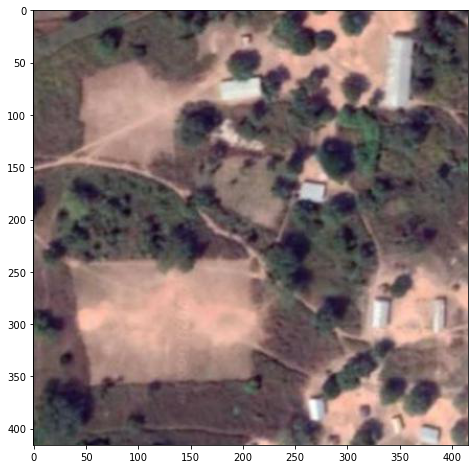

In [808]:
display(image_g_det)

In [824]:
images_data = pd.read_gbq('SELECT * FROM `sidhouses.osm_data.image_ds_info`')

In [825]:
images_data.head()

drive_id                village_name  \
0  1ERUqn0IWwczeIWYqkTJhv61XOVB5IExf                   ALAFIAROU   
1  1iRSSNT0StWUtXJqt8IMj_OUmp1sokQil                 TAKOU GANDO   
2  1JhDdg8O_fosVOdn6szTA3mMPmg10InAp  PERANGOU BAGRI - GBÈRANKOU   
3  1oP0XKEsZqgwdSWrswPucb6MoXxDbNi8f           KPARISSEROU PEULH   
4  1__sch8bmeRnaYZzcZiLIDxbrHiGzZYsZ                   MOUSSOURE   

                                                path      lat_0    lon_0  \
0        /Users/daniel/OAN/SID/poc/osm/ALAFIAROU.png  10.068964  3.07710   
1      /Users/daniel/OAN/SID/poc/osm/TAKOU GANDO.png   9.860075  3.22100   
2  /Users/daniel/OAN/SID/poc/osm/PERANGOU BAGRI -...  10.120093  3.43628   
3  /Users/daniel/OAN/SID/poc/osm/KPARISSEROU PEUL...   9.952434  3.14307   
4        /Users/daniel/OAN/SID/poc/osm/MOUSSOURE.png  10.055894  3.04107   

   deg_per_px_lat  deg_per_px_lon  n_houses layer  
0        0.000005        0.000005        10  bing  
1        0.000005        0.000005        19  bing  
2        0.000005        0.000005        53  bing  
3        0.000005        0.000005         7  esri  
4        0.000005        0.000005        39  esri

In [826]:
images_data['layer'].unique()

array(['bing', 'esri', 'maxar', 'mapbox'], dtype=object)

In [827]:
maxar_images = images_data[images_data['layer'] == 'maxar']['drive_id'].to_list()

In [828]:
images_routes = [im_route 
          for im_route in os.listdir(train_path)
          if 'jpg' in im_route]

In [829]:
images_routes_max = [img for img in images_routes if img.split('_')[0] in maxar_images]

In [830]:
len(images_routes_max)

179

In [845]:
vill = random.choice(images_routes_max)
vill

'1LTZhpFij3OtgDYps3fHDMxbokFk9--yG_9_png.rf.471ebc28b8d1fc55903a7a2147a77466.jpg'

In [1312]:
vill='1DSneo4A8uBgd9QQJF-npDiLdjBHpfrpT_2_png.rf.32e3e38fc6cd08bc77f69752fc01788f.jpg'

In [846]:
image_random = cv2.imread(train_path+vill)

In [903]:
good_detection=[
'1R226VU55ww5iO0hP2rUW0UC1AEXPtrGK_7_png.rf.139774874a6171af98a3145ce727818c.jpg',
 '1LTZhpFij3OtgDYps3fHDMxbokFk9--yG_6_png.rf.455d9739abd757889b37837ed503d18e.jpg',
 '1FZ6n-TFcBIpXSOSMey8vIgKe2CEYafSk_2_png.rf.74e0e74063f34790832221d2269ca023.jpg',
 '1IKxADxsOpd4y6yF5XPs1VVI13w4EH8Uu_8_png.rf.57be54b7e5ec9b662cc63ecb65dcbeeb.jpg',
 '1kpEW8kttexiV6sfRuKs8SroGEiFQf5T1_2_png.rf.e96837a2ee146fd6e6f3d36f7012b5cd.jpg',
 '1IKxADxsOpd4y6yF5XPs1VVI13w4EH8Uu_4_png.rf.f189c884cc2dfd3b13bfe55510de890a.jpg',
 '1DSneo4A8uBgd9QQJF-npDiLdjBHpfrpT_6_png.rf.2aac481602f3915d44d722481d70f141.jpg',
 '1Ctd2BTS32d8xSXKAXOOltmwItgUIUlHQ_7_png.rf.87844c33c7200ad4d5e9f7d3c4ed897f.jpg',
  '3_JPG.rf.285a65e864c2e1e9ac71de80b7ad29f9.jpg',
    '17_JPG.rf.e817cc606bffb7bdd1691ac7650cffa1.jpg',
 '1ValpERwhZ9IBbHp9iWc8BD4VWVgm0TxQ_7_png.rf.69b07e5f8aa81cdd92958953d0f92580.jpg']

In [1170]:
great_detection = []

In [1179]:
great_detection.append(vill)

In [1180]:
great_detection

['1IKxADxsOpd4y6yF5XPs1VVI13w4EH8Uu_9_png.rf.0e78ae825200f96e4a84f4ef2c258c39.jpg',
 '1LTZhpFij3OtgDYps3fHDMxbokFk9--yG_8_png.rf.249eed84738d0d2d18e5e327bc1b3b21.jpg']

In [835]:
r_p

'/Users/daniel/OAN/SID/dataset/train/'

In [898]:
vill = random.choice(images_routes_max)
vill

'1IKxADxsOpd4y6yF5XPs1VVI13w4EH8Uu_6_png.rf.d3243a6760559849a2c17d6b436a94b5.jpg'

In [1190]:
vill = good_detection[4]

In [1169]:
image_g_det = cv2.imread(train_path+'/'+vill)

In [ ]:
image = image_g_det.copy()
c_blue=0
suma_pixel = []
for i_blue in np.arange(4,20,1):
    blue_low= 10*i_blue
    blue_up = 255
    mask_blue = image.copy()
    mask_blue_m = image.copy()
    mask_blue[mask_blue_m[:,:,c_blue] <= blue_low] = [0,0,0]
    mask_blue[blue_low <= mask_blue_m[:,:,c_blue]] = [255,255,255]
    mask_blue[blue_up <= mask_blue_m[:,:,c_blue]] = [0,0,0]

    mask_blue = mask_blue[:,:,0]

    suma = np.sum(mask_blue.astype(np.int64)).astype(np.int64)

    suma_pixel.append({'suma':suma,'b_down':blue_low})

df_suma =pd.DataFrame(suma_pixel)


In [ ]:
df_suma['suma'] = 100*df_suma['suma'].apply(float)/(416*416*255)

In [ ]:
df_suma = df_suma[(100*1000/(416*416*255) < df_suma['suma']) &
                  (df_suma['suma'] < 150000000)].reset_index()

In [ ]:
df_suma['porcentaje'] = 100*df_suma['suma'].pct_change().abs()
df_pctss = df_suma['porcentaje']
df_local_max = df_suma[(df_pctss.shift(1) < df_pctss) & 
        (df_pctss.shift(-1) < df_pctss)].sort_values(by='porcentaje',
                                                                  ascending= False
                                                    ).reset_index()
if 0 < len(df_local_max):
    blue_low = df_local_max.iloc[1]['b_down'].max()
    print('b_low',blue_low)
    pos = df_local_max.iloc[0]['suma'].max()
    lot_pos = 100000 < pos
else:
    blue_low = 100
    lot_pos = False
    print('b_low default',blue_low)

In [ ]:
df_suma['umbral_azul'] = df_suma['b_down']

In [ ]:
f = plt.figure(figsize=(10,5))
sns.lineplot(x='umbral_azul',y='porcentaje',data=df_suma, label='cambio')
sns.lineplot(x='umbral_azul',y='suma',data=df_suma,label='%positivo')
plt.grid()
plt.legend()

In [ ]:
df_suma

In [ ]:
sns.lineplot(x='b_down',y='suma',data=df_suma)

In [ ]:
df_suma['pct_change_2'] = df_suma['pct_change'].pct_change().abs()

In [ ]:
sns.lineplot(x='b_down',y='pct_change_2',data=df_suma)

In [ ]:
#df_suma[df_suma['suma'] != 0]

b_low 100.0
(array([  0, 765], dtype=int32), array([171412,   1644]))
1 3 2 3
TP 10, FP 1 FN 3
precis = 90.91%, acc = 76.92%, f1 = 83.33%


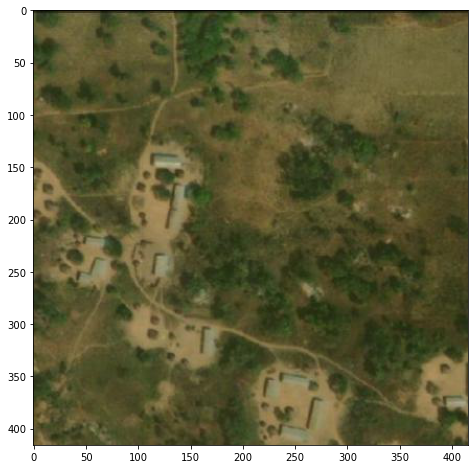

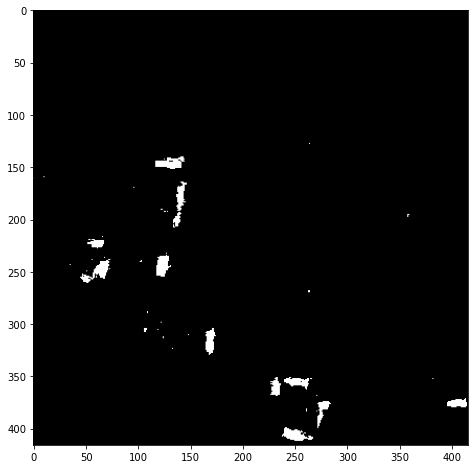

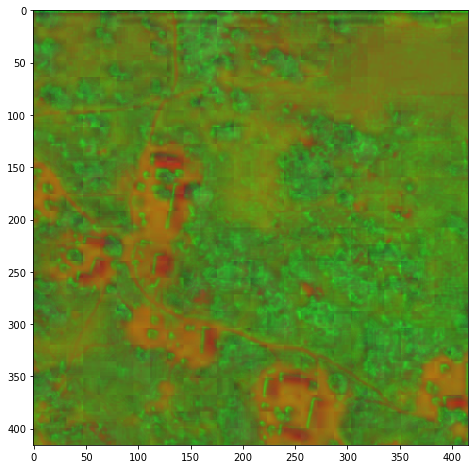

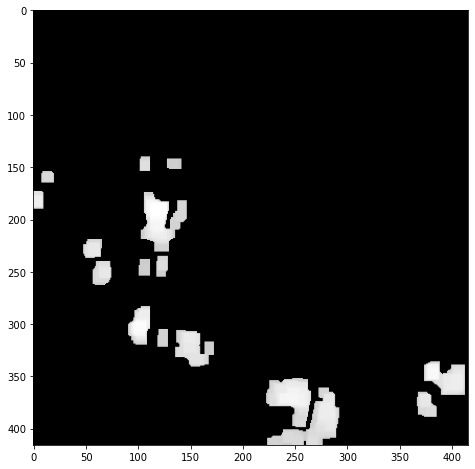

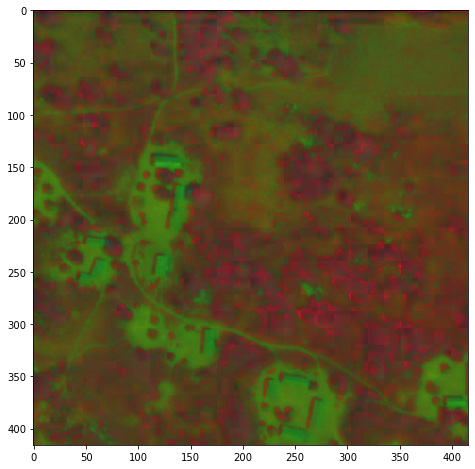

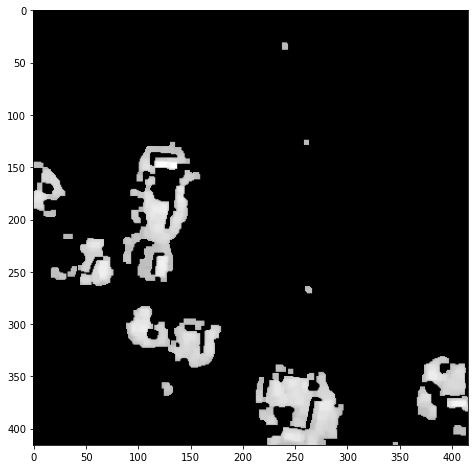

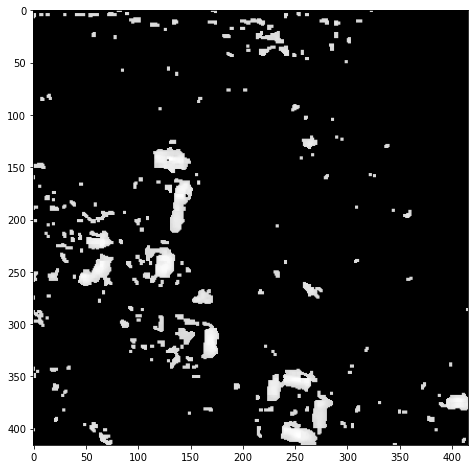

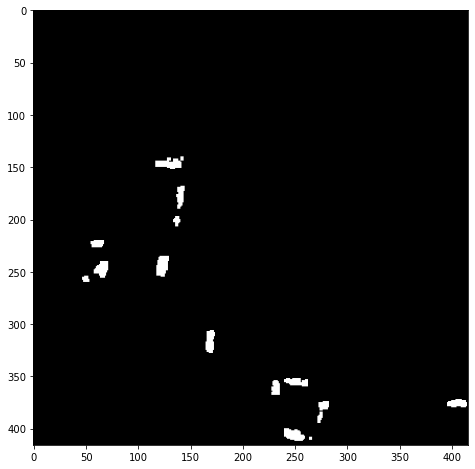

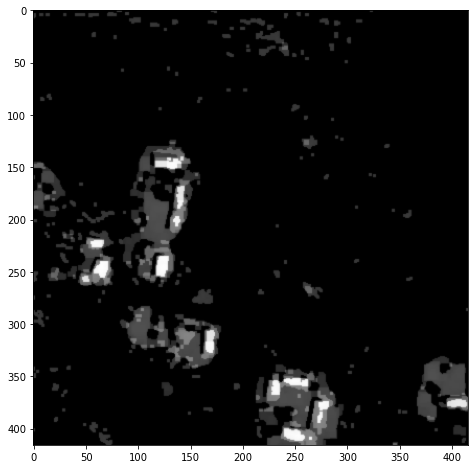

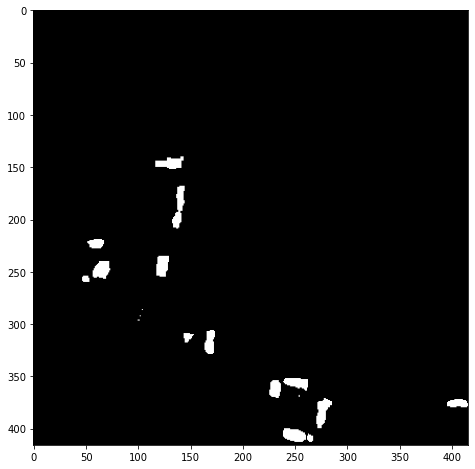

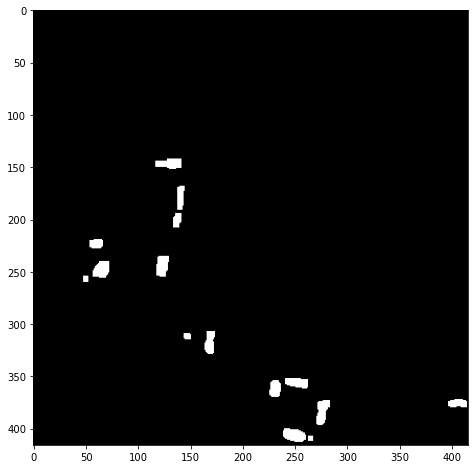

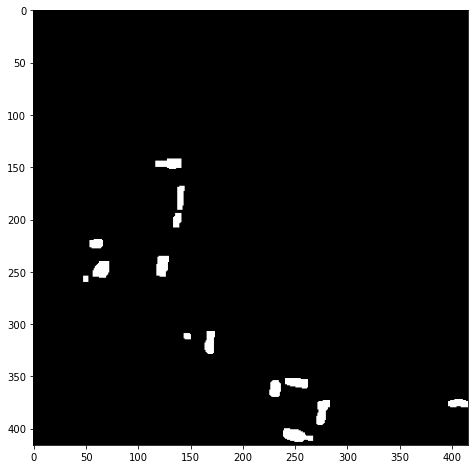

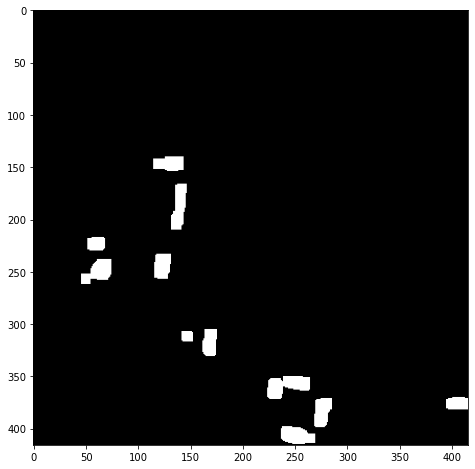

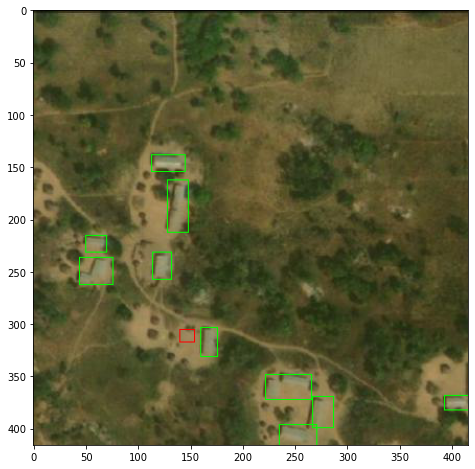

In [1191]:
i,j,z,w = 1,3,2,3
g_i=4
g_i=4
train=True
ss_im = True
if train:
    r_p = train_path
    df_an = df_anot
else:
    r_p = test_path
    df_an = df_anot_test
    
image_g_det = cv2.imread(r_p+vill)
display(image_g_det)
im_draw,boxes,box_tp = detect_houses(image_g_det,vill,df_anot,i,j,z,w,ss_im)
display(im_draw)

df_houss = df_an[df_an['im_path'] == vill]


real_b = df_houss.shape[0]

true_pos = len(box_tp)
false_pos = len(boxes)-len(box_tp)
false_neg = real_b-len(box_tp)
pr, acc, f1 = compute_metrics(true_pos, false_pos, false_neg)

print(i,j,z,w)
print('TP {}, FP {} FN {}'.format(true_pos,false_pos,false_neg))
print('precis = {}%, acc = {}%, f1 = {}%'.format(round(100*pr,2),round(acc*100,2),round(f1*100,2)))

b_low 100.0
Running inference on: 1kpEW8kttexiV6sfRuKs8SroGEiFQf5T1_2_png.rf.e96837a2ee146fd6e6f3d36f7012b5cd.jpg
1 3 2 3


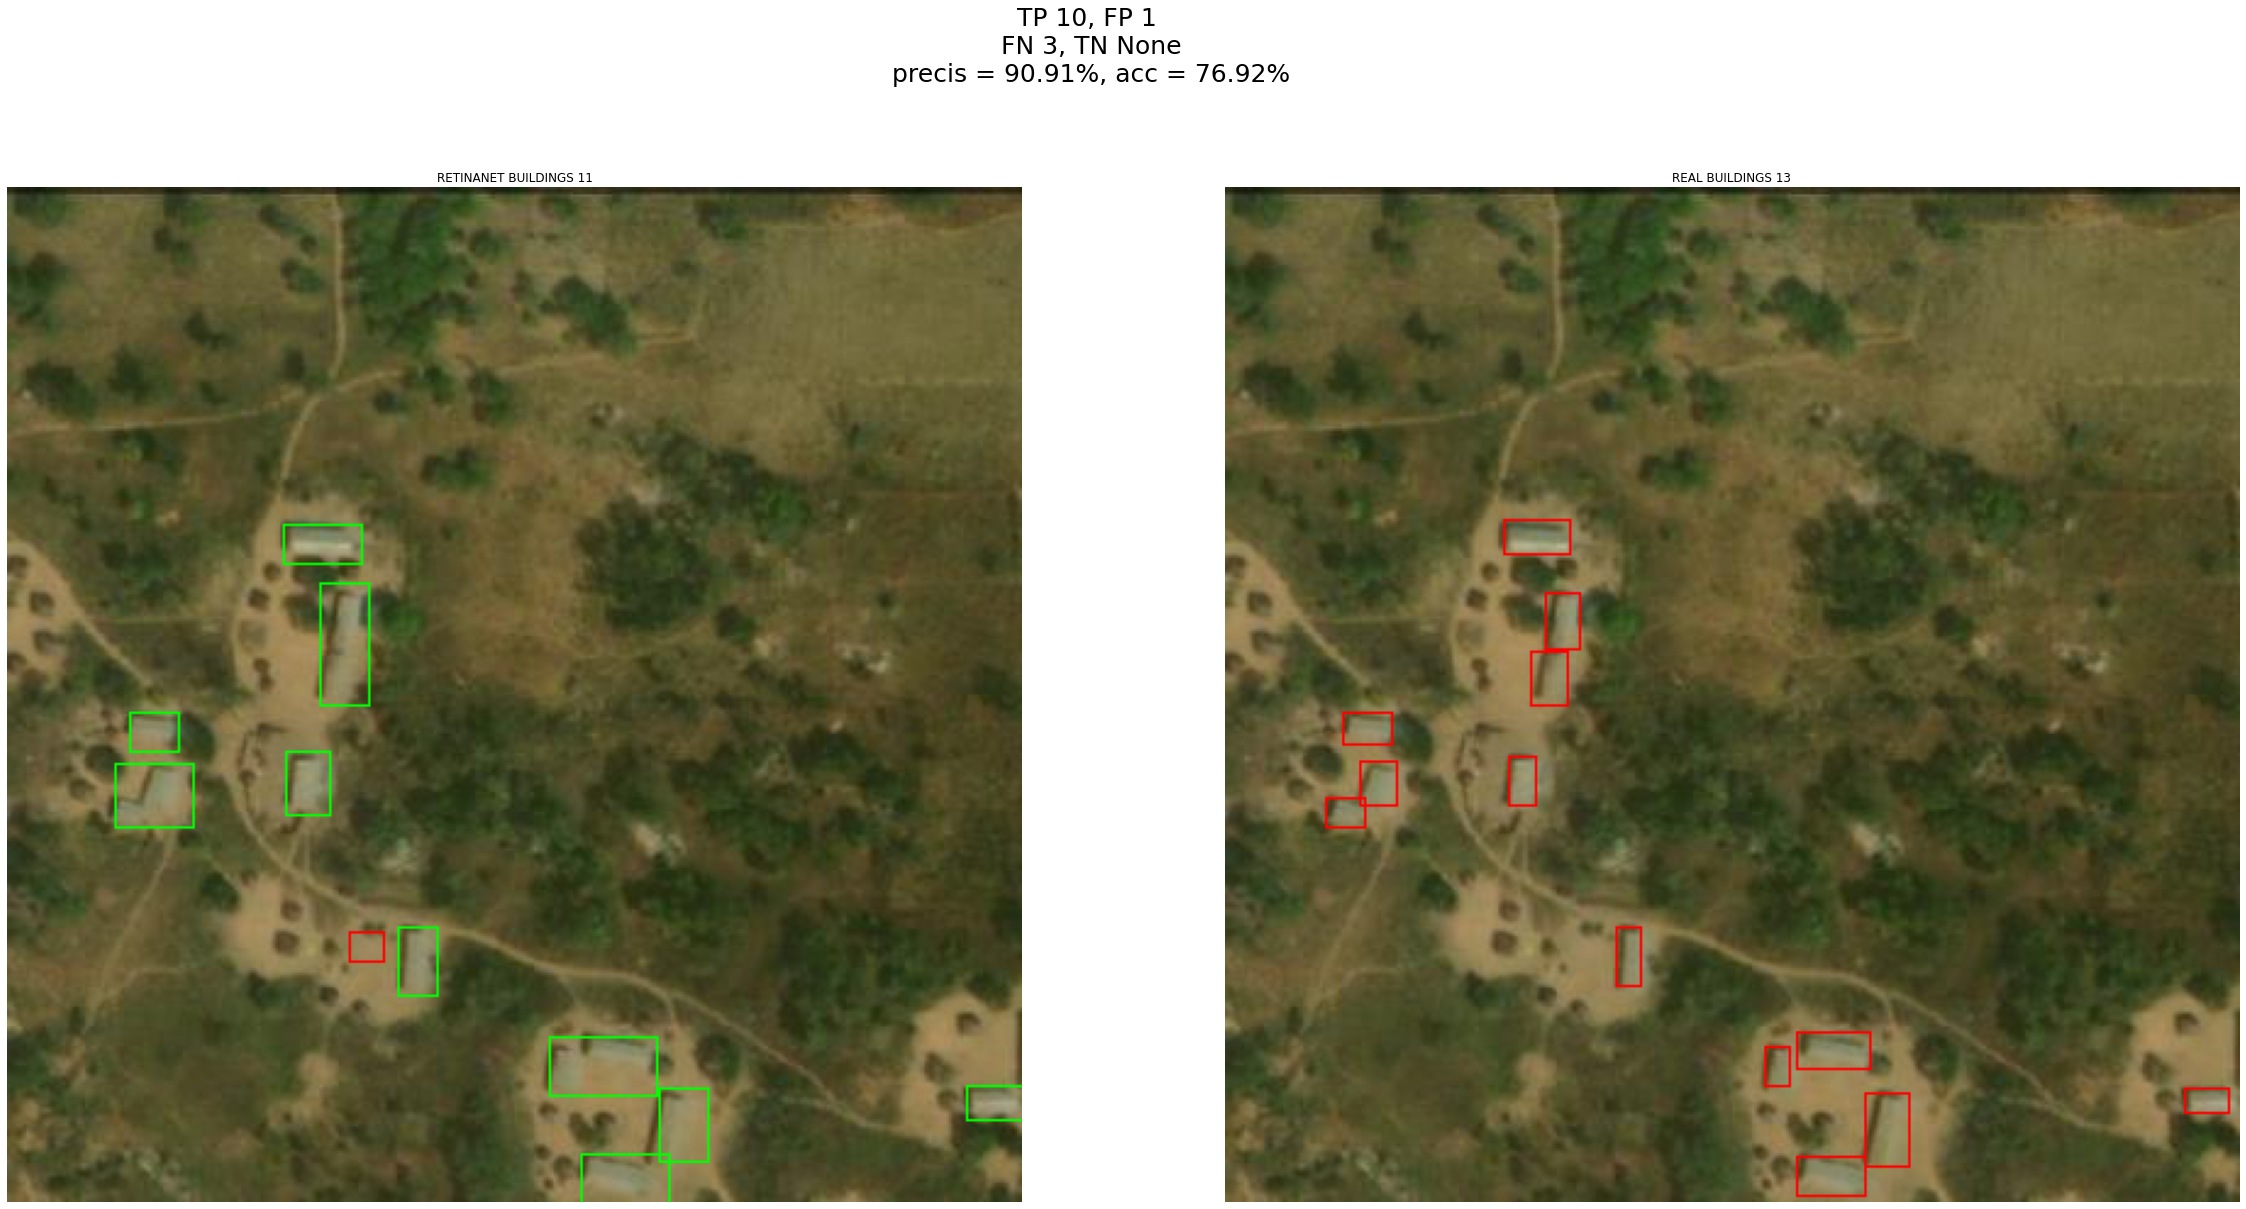

In [1140]:
tps = []
fps = []
fns = []
im =vill
show_images = True
df_houss = df_an[df_an['im_path'] == im]
im_path = r_p + im

image_t_det = cv2.imread(im_path)

im_draw,boxes,box_tp = detect_houses(image_t_det,im,df_an,i,j,z,w)
im_draw = cv2.cvtColor(im_draw, cv2.COLOR_BGR2RGB)

image = cv2.cvtColor(image_t_det, cv2.COLOR_BGR2RGB)

real_b = df_houss.shape[0]

true_pos = len(box_tp)
false_pos = len(boxes)-len(box_tp)
false_neg = real_b-len(box_tp)
tps.append(true_pos)
fps.append(false_pos)
fns.append(false_neg)
pr, acc, f1 = compute_metrics(true_pos, false_pos, false_neg)

if show_images:
    print('Running inference on: ' + im)
    print(i,j,z,w)
    f, ax = plt.subplots(1,2,figsize=(40, 20))

    for hous in df_houss['box'].to_list():
        x1, y1, x2, y2 = hous[0],hous[1],hous[2],hous[3]
        #label = str(classes[class_ids[i]])
        label = ""
        color = (255, 0, 0)
        #cv2.rectangle(imagen, start point, end point, color, grosor de la línea)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)


    plt.axis('off')
    ax[0].imshow(im_draw)
    ax[1].imshow(image)
    ax[0].axis('off')
    ax[1].axis('off')

    ax[0].set_title('RETINANET BUILDINGS {}'.format(len(boxes)))
    ax[1].set_title('REAL BUILDINGS {}'.format(real_b))


    title= 'TP {}, FP {}\n FN {}, TN {}\n precis = {}%, acc = {}%'
    plt.suptitle(title.format(true_pos,false_pos,false_neg,None,round(100*pr,2),round(acc*100,2)),fontsize=25)

    plt.show()

### ON TEST DATA

In [17]:
test_path = '/Users/daniel/OAN/SID/dataset/test/'
df_anot_test = pd.read_csv(test_path+'_annotations.csv',header=None)
df_anot_test.columns = ['im_path','l','t','r','b','type']

df_anot_test['box'] = df_anot_test.apply(lambda x: (x['l'],x['t'],x['r'],x['b']),axis=1)

In [18]:
images_test = [jpg for jpg in os.listdir(test_path) 
               if 'jpg' in jpg]

In [965]:
images_test = [img for img in images_test if img.split('_')[0] in maxar_images]

In [19]:
len(images_test)

37

In [23]:
tps = []
fps = []
fns = []
im_root_path = test_path

show_images = False


i,j,z,w = 1,3,2,3
for im in images_test:
    df_houss = df_anot_test[df_anot_test['im_path'] == im]
    im_path = im_root_path + im

    image_t_det = cv2.imread(im_path)

    im_draw,boxes,box_tp = detect_houses(image_t_det,im,df_anot_test,i,j,z,w)
    im_draw = cv2.cvtColor(im_draw, cv2.COLOR_BGR2RGB)
    
    image = cv2.cvtColor(image_t_det, cv2.COLOR_BGR2RGB)

    real_b = df_houss.shape[0]

    true_pos = len(box_tp)
    false_pos = len(boxes)-len(box_tp)
    false_neg = real_b-len(box_tp)
    tps.append(true_pos)
    fps.append(false_pos)
    fns.append(false_neg)
    pr, acc, f1 = compute_metrics(true_pos, false_pos, false_neg)

    if show_images:
        print('Running inference on: ' + im)
        print(i,j,z,w)
        f, ax = plt.subplots(1,2,figsize=(40, 20))

        for hous in df_houss['box'].to_list():
            x1, y1, x2, y2 = hous[0],hous[1],hous[2],hous[3]
            #label = str(classes[class_ids[i]])
            label = ""
            color = (255, 0, 0)
            #cv2.rectangle(imagen, start point, end point, color, grosor de la línea)
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)


        plt.axis('off')
        ax[0].imshow(im_draw)
        ax[1].imshow(image)
        ax[0].axis('off')
        ax[1].axis('off')

        ax[0].set_title('RETINANET BUILDINGS {}'.format(len(boxes)))
        ax[1].set_title('REAL BUILDINGS {}'.format(real_b))


        title= 'TP {}, FP {}\n FN {}, TN {}\n precis = {}%, acc = {}%'
        plt.suptitle(title.format(true_pos,false_pos,false_neg,None,round(100*pr,2),round(acc*100,2)),fontsize=25)

        plt.show()

b_low 100.0
b_low default 100
b_low default 100
b_low 110.0
b_low 130.0
b_low 110.0
b_low default 100
b_low 160.0
b_low 100.0
b_low default 100
b_low 100.0
b_low default 100
b_low default 100
b_low 120.0
b_low 160.0
b_low 100.0
b_low 100.0
b_low 100.0
b_low 100.0
b_low default 100
b_low 130.0
b_low 160.0
b_low 100.0
b_low default 100
b_low default 100
b_low 100.0
b_low 110.0
b_low 160.0
b_low 140.0
b_low default 100
b_low default 100
b_low 120.0
b_low 100.0
b_low 110.0
b_low 100.0
b_low 110.0
b_low 110.0


In [24]:
print(i,j,z,w)
print('TP {}, FP {} FN {}'.format(sum(tps),sum(fps),sum(fns)))
pr, acc, f1 = compute_metrics(sum(tps),sum(fps),sum(fns))
print('precis = {}%, acc = {}%, f1 = {}%'.format(round(100*pr,2),round(acc*100,2),round(f1*100,2)))

1 3 2 3
TP 276, FP 140 FN 464
precis = 66.35%, acc = 37.3%, f1 = 47.75%


In [954]:
print(i,j,z,w)
print('TP {}, FP {} FN {}'.format(sum(tps),sum(fps),sum(fns)))
pr, acc, f1 = compute_metrics(sum(tps),sum(fps),sum(fns))
print('precis = {}%, acc = {}%, f1 = {}%'.format(round(100*pr,2),round(acc*100,2),round(f1*100,2)))

1 3 2 3
TP 80, FP 14 FN 62
precis = 85.11%, acc = 56.34%, f1 = 67.8%


In [968]:
print(i,j,z,w)
print('TP {}, FP {} FN {}'.format(sum(tps),sum(fps),sum(fns)))
pr, acc, f1 = compute_metrics(sum(tps),sum(fps),sum(fns))
print('precis = {}%, acc = {}%, f1 = {}%'.format(round(100*pr,2),round(acc*100,2),round(f1*100,2)))

1 3 2 3
TP 89, FP 18 FN 53
precis = 83.18%, acc = 62.68%, f1 = 71.49%


In [959]:
print(i,j,z,w)
print('TP {}, FP {} FN {}'.format(sum(tps),sum(fps),sum(fns)))
pr, acc, f1 = compute_metrics(sum(tps),sum(fps),sum(fns))
print('precis = {}%, acc = {}%, f1 = {}%'.format(round(100*pr,2),round(acc*100,2),round(f1*100,2)))

1 3 2 3
TP 250, FP 137 FN 490
precis = 64.6%, acc = 33.78%, f1 = 44.37%


In [964]:
print(i,j,z,w)
print('TP {}, FP {} FN {}'.format(sum(tps),sum(fps),sum(fns)))
pr, acc, f1 = compute_metrics(sum(tps),sum(fps),sum(fns))
print('precis = {}%, acc = {}%, f1 = {}%'.format(round(100*pr,2),round(acc*100,2),round(f1*100,2)))

1 3 2 3
TP 276, FP 154 FN 464
precis = 64.19%, acc = 37.3%, f1 = 47.18%


In [1195]:
print(i,j,z,w)
print('TP {}, FP {} FN {}'.format(sum(tps),sum(fps),sum(fns)))
pr, acc, f1 = compute_metrics(sum(tps),sum(fps),sum(fns))
print('precis = {}%, acc = {}%, f1 = {}%'.format(round(100*pr,2),round(acc*100,2),round(f1*100,2)))

1 3 2 3
TP 274, FP 142 FN 466
precis = 65.87%, acc = 37.03%, f1 = 47.4%
